## Chromatophores - Load processed data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import napari
%config InlineBackend.figure_format = 'retina'

In [7]:
from process_video import load_video_zarr
from octron.sam2_octron.helpers.video_loader import probe_video # This will fail if OCTRON is not installed?

In [9]:
video_path = '/Users/horst/Library/CloudStorage/GoogleDrive-hobenhaus@gmail.com/My Drive/OCTRON/Project folders - in progress/chromatophores/original videos/resized/0N3A1508_resized.mp4'
video_dict = probe_video(video_path)

File: 0N3A1508_resized.mp4
Codec: h264
Resolution: 1364 x 720
Frame Rate: 59.94 fps
Number of frames: 3112
Duration: 51.92 seconds


### Load results back in 

In [10]:
zarr_path, parquet_path, video, mask_zarr = load_video_zarr(Path(video_path),
                                                            remove_previous_zarr=False
                                                            )
export_path = parquet_path.parent
num_frames = video.shape[0]
image_height = video.shape[1]
image_width = video.shape[2]

chroma_data = pd.read_parquet(parquet_path)
print(chroma_data.columns)

Loading existing zarr mask file
Existing keys in zarr archive: ['masks']
Zarr store info:
Type               : Array
Zarr format        : 3
Data type          : DataType.int32
Shape              : (3112, 720, 1364)
Chunk shape        : (250, 720, 1364)
Order              : C
Read-only          : False
Store type         : LocalStore
Filters            : ()
Serializer         : BytesCodec(endian=<Endian.little: 'little'>)
Compressors        : (ZstdCodec(level=0, checksum=False),)
No. bytes          : 12224931840 (11.4G)
Index(['label', 'area', 'area_bbox', 'area_convex', 'centroid-0', 'centroid-1',
       'orientation', 'eccentricity', 'solidity', 'extent',
       'major_axis_length', 'minor_axis_length', 'corner_top_left_mean_l',
       'corner_top_right_mean_l', 'corner_bottom_left_mean_l',
       'corner_bottom_right_mean_l', 'mean_l', 'mean_a', 'mean_b', 'mean_hues',
       'mean_sats', 'mean_vals', 'frame', 'region_id', 'centroid_dist'],
      dtype='object')


### Interpolate over missing data

In [11]:
import warnings
# Suppress the DeprecationWarning for groupby-apply on grouping columns
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Interpolate numerical columns in chroma_data per region_id, both forward and backward
chroma_data = chroma_data.groupby('region_id').apply(
    lambda group: group.interpolate(method='linear', limit_direction='both', axis=0)
).reset_index(drop=True)


In [12]:
chroma_ids = np.unique(chroma_data.region_id)
chroma_frames = np.unique(chroma_data.frame)
print(f'{len(chroma_ids)} chromatophores found over {len(chroma_frames)} frames')

585 chromatophores found over 3112 frames


### Plot example frame

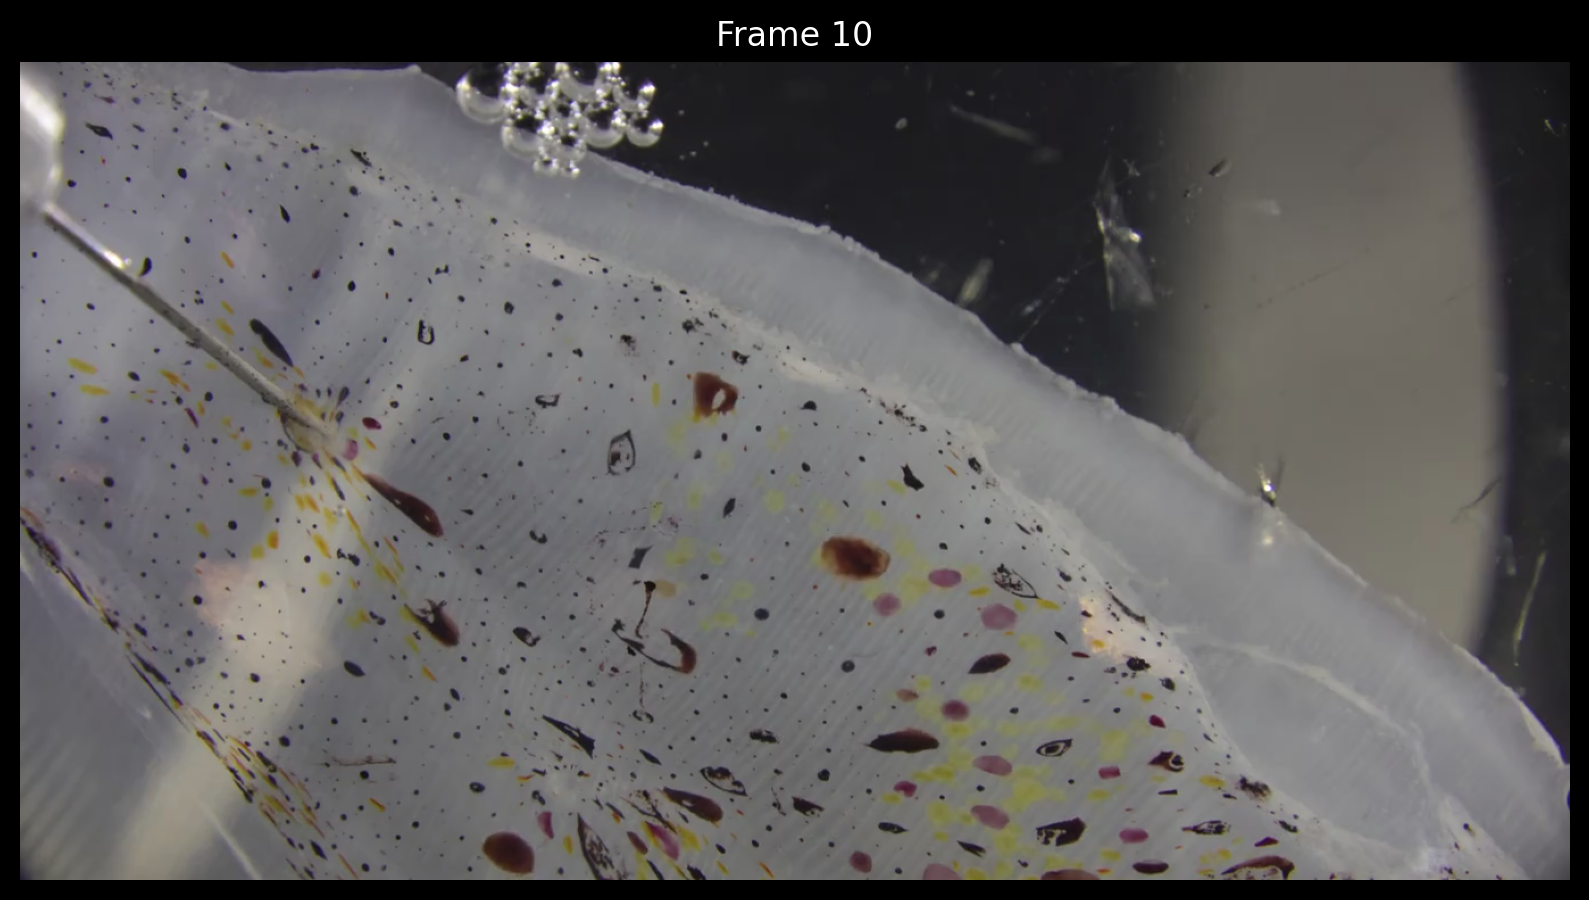

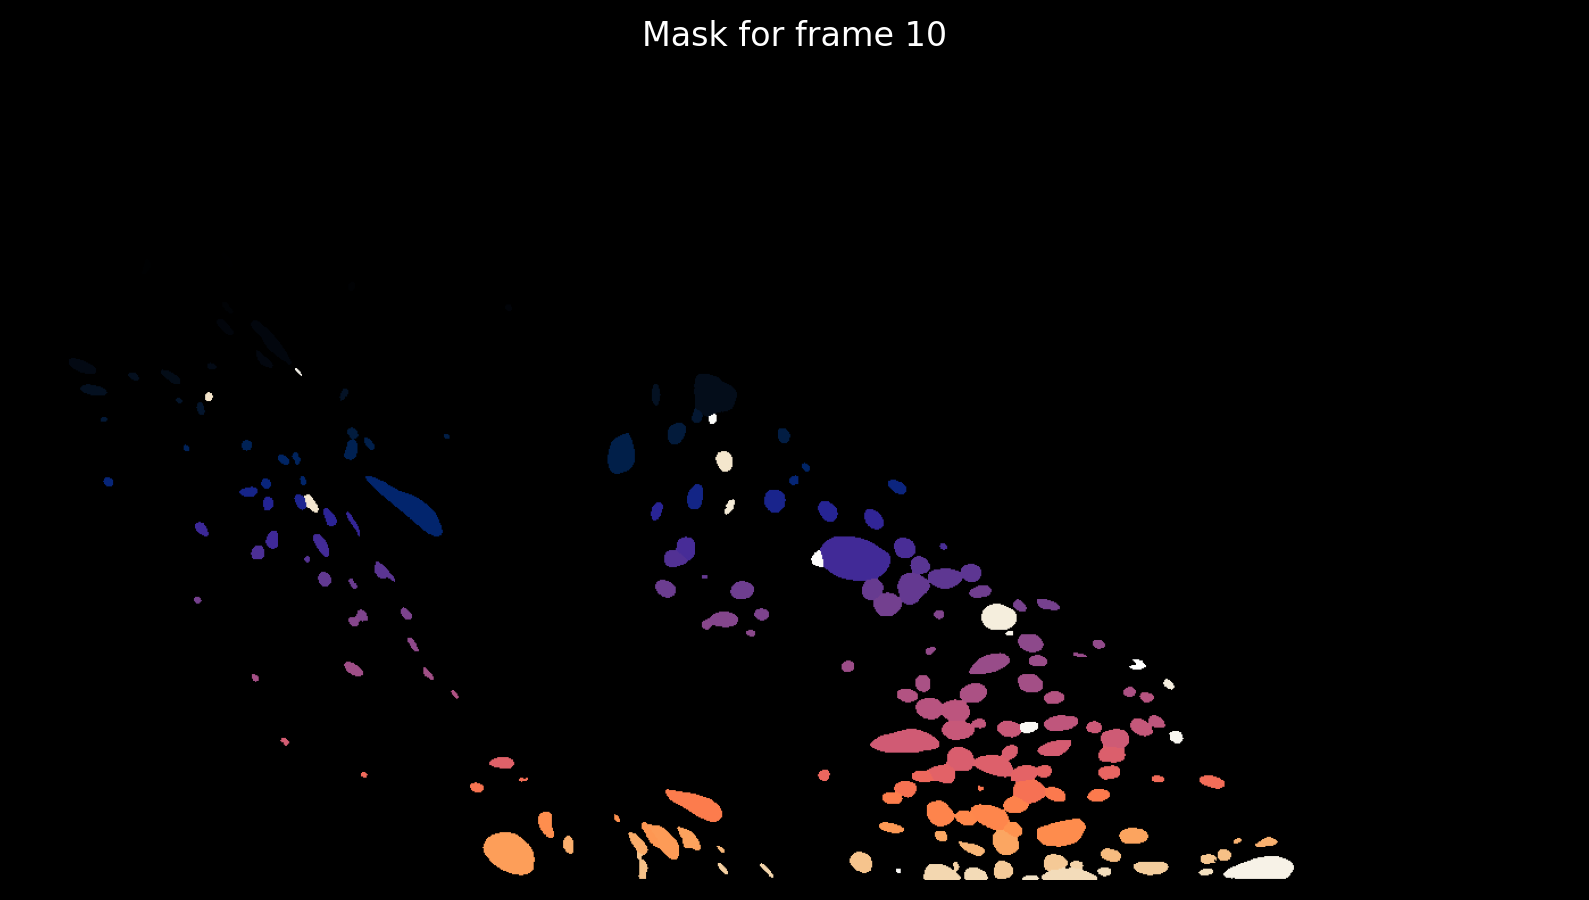

In [13]:
frame_index = 10
mask_zarr[frame_index]


plt.figure(figsize=(10, 7))
plt.imshow(video[frame_index])
plt.title(f'Frame {frame_index}')
plt.axis('off')

plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(mask_zarr[frame_index], cmap='cmr.torch')
plt.title(f'Mask for frame {frame_index}')
plt.axis('off')
plt.show()

### Plot area over time for some examples

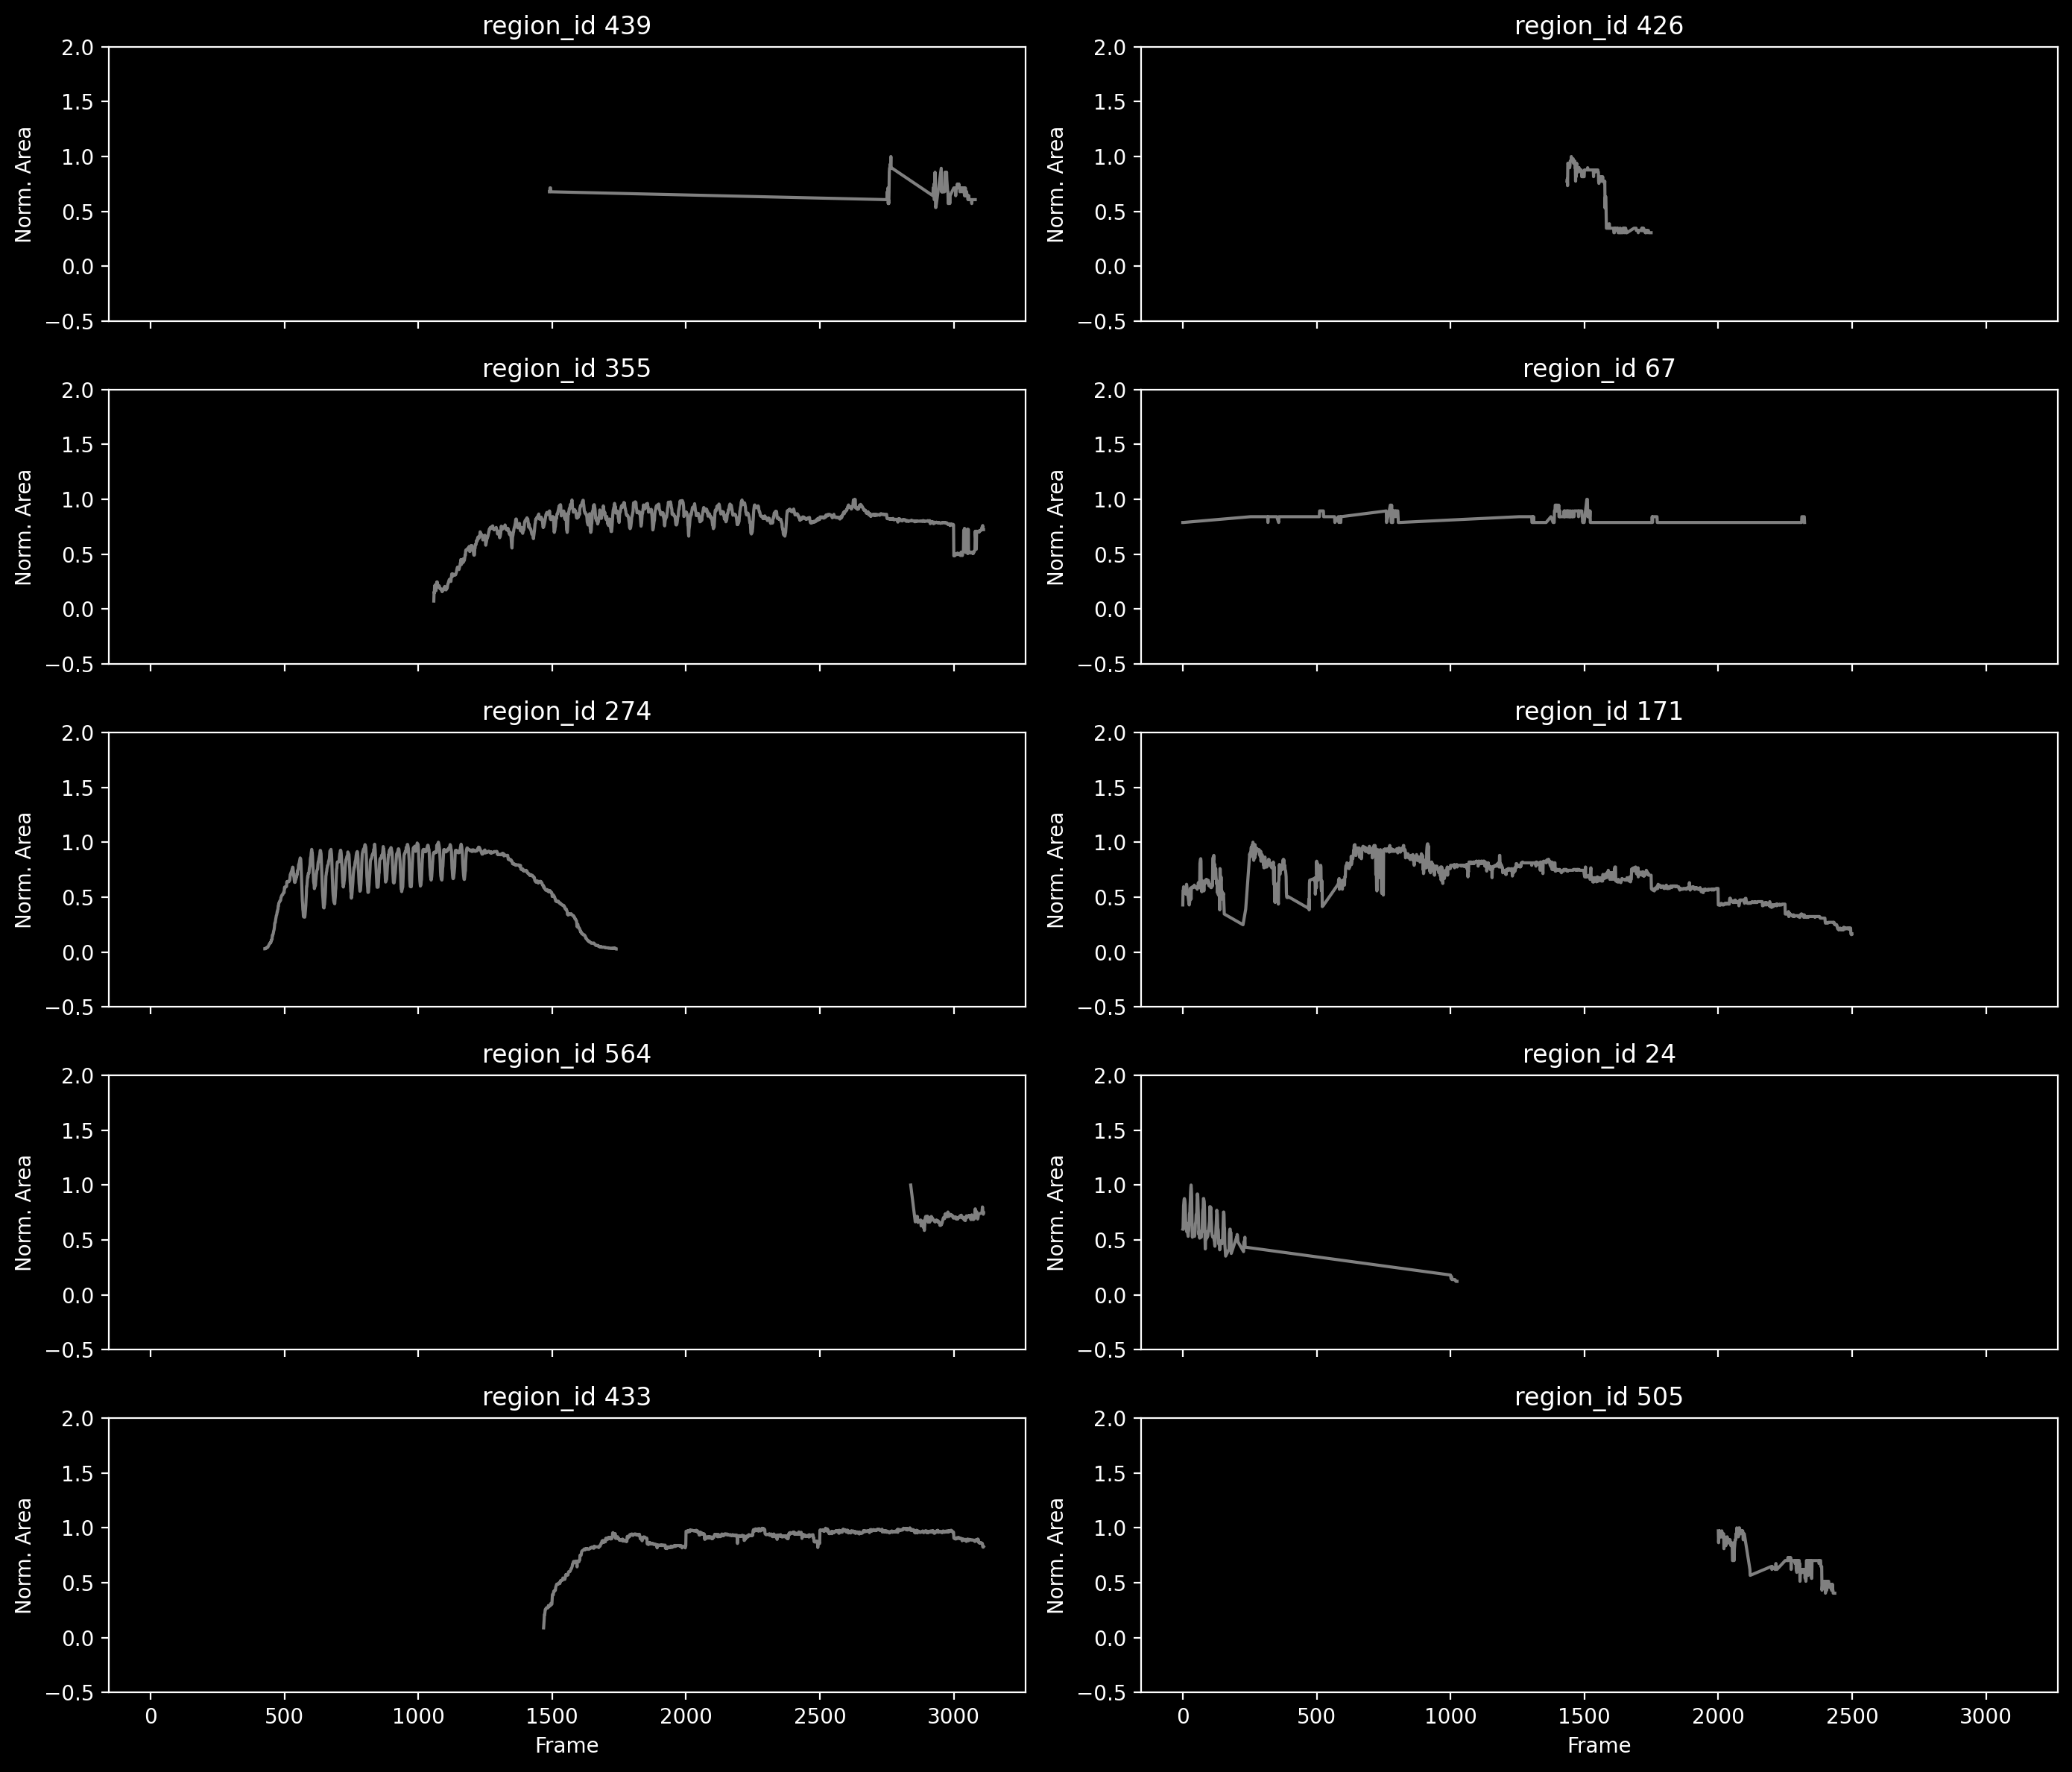

In [14]:
# Plot area over frame for 10 random chroma_ids, each on a separate axis
sample_ids = np.random.choice(chroma_ids, size=10, replace=False)

fig, axes = plt.subplots(5, 2, figsize=(14, 12), sharex=True)
axes = axes.flatten()

for ax, region_id in zip(axes, sample_ids):
    subset = chroma_data[chroma_data['region_id'] == region_id]
    area = subset['area']
    # normalize area 
    area /= np.nanmax(area)
    ax.plot(subset['frame'], subset['area'], color='grey')
    ax.set_title(f'region_id {region_id}')
    ax.set_ylabel('Norm. Area')
    ax.set_ylim(-.5,np.nanmax(area)*2)
    ax.grid(False)

axes[-1].set_xlabel('Frame')
axes[-2].set_xlabel('Frame')
plt.tight_layout()
plt.show()


### When did the laser pulses occurr? 

In [15]:
threshold_rel_laser = 1.005 # e.g. 1.25 x median is threshold for detecting laser stim 
frame_data = chroma_data.groupby('frame').mean(numeric_only=True).reset_index()

Found 5 laser pulses


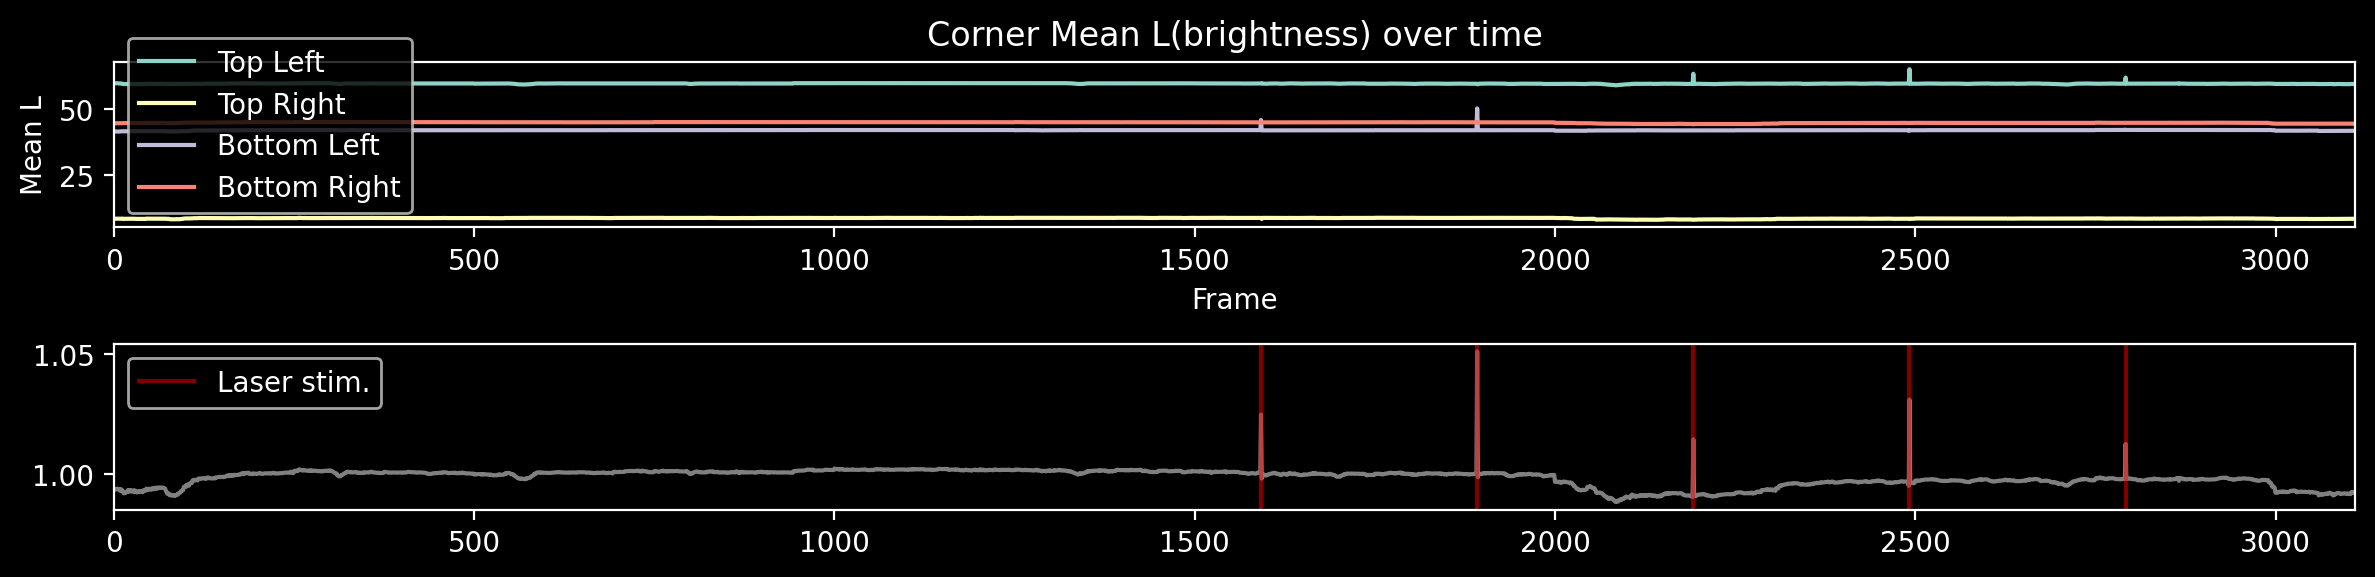

In [16]:
figure = plt.figure(figsize=(12, 3))
ax = figure.add_subplot(211)
ax.plot(frame_data['frame'], frame_data['corner_top_left_mean_l'], label='Top Left')
ax.plot(frame_data['frame'], frame_data['corner_top_right_mean_l'], label='Top Right')
ax.plot(frame_data['frame'], frame_data['corner_bottom_left_mean_l'], label='Bottom Left')
ax.plot(frame_data['frame'], frame_data['corner_bottom_right_mean_l'], label='Bottom Right')
ax.set_xlim(0,frame_data['frame'].max())
ax.set_xlabel('Frame')
ax.set_ylabel('Mean L')
ax.set_title(f'Corner Mean L(brightness) over time')
ax.legend()

# Get average and peaks 
average_of_corners = np.nanmean(np.stack([frame_data['corner_top_left_mean_l'],
                frame_data['corner_top_right_mean_l'],
                frame_data['corner_bottom_left_mean_l'],
                frame_data['corner_bottom_right_mean_l']]), axis=0)
average_of_corners /= np.nanmedian(average_of_corners)
laser_indices = np.argwhere(average_of_corners>threshold_rel_laser)
print(f'Found {len(laser_indices)} laser pulses')

ax = figure.add_subplot(212)
ax.plot(frame_data['frame'], average_of_corners, color='grey')
ax.set_xlim(0,frame_data['frame'].max())
for no_i, i in enumerate(laser_indices):
    if not no_i:
        ax.axvline(x=i, color='r', alpha=.5, label='Laser stim.')
    else:
        ax.axvline(x=i, color='r', alpha=.5,)
ax.legend()
plt.tight_layout()
plt.show()

### Cluster chromatophores by spectral content (kmeans with n=3)

In [17]:
from sklearn.cluster import KMeans
region_avg = chroma_data.groupby('region_id').mean(numeric_only=True)

# Use LAB and HSV values to cluster 
cluster_n = 3
sub_dataframe = region_avg[['mean_a','mean_b', 'mean_l', 'mean_hues', 'mean_vals', 'mean_sats']].values
kmeans = KMeans(n_clusters=cluster_n, random_state=0, n_init=500, max_iter=5_000)
region_avg['kmeans_label'] = kmeans.fit_predict(sub_dataframe)
chroma_data = chroma_data.merge(region_avg['kmeans_label'], left_on='region_id', right_index=True, how='left')

In [18]:
chroma_data[chroma_data.region_id==10]

,label,area,area_bbox,area_convex,centroid-0,centroid-1,orientation,eccentricity,solidity,extent,...,mean_l,mean_a,mean_b,mean_hues,mean_sats,mean_vals,frame,region_id,centroid_dist,kmeans_label
14526,11,118.0,225.0,126.0,232.932203,179.652542,0.790793,0.915985,0.936508,0.524444,...,45.395154,-2.234428,26.044427,0.136197,0.462763,0.462878,0,10,0.016949,0
14527,11,118.0,225.0,125.0,232.932203,179.669492,0.795228,0.917463,0.944000,0.524444,...,45.405652,-2.252109,26.057471,0.136185,0.462835,0.462911,1,10,0.016949,0
14528,11,117.0,225.0,125.0,232.871795,179.615385,0.797798,0.914680,0.936000,0.520000,...,45.395156,-2.231511,26.151936,0.136147,0.464658,0.463080,2,10,0.075707,0
14529,11,118.0,225.0,126.0,232.847458,179.635593,0.797313,0.911930,0.936508,0.524444,...,45.422352,-2.212275,25.983041,0.135935,0.461779,0.463144,3,10,0.054604,0
14530,10,119.0,225.0,126.0,232.907563,179.689076,0.794619,0.914804,0.944444,0.528889,...,45.417467,-2.205935,25.886488,0.135870,0.460204,0.462976,4,10,0.061650,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14874,9,21.0,49.0,23.0,232.142857,179.666667,0.704720,0.958359,0.913043,0.428571,...,40.541050,5.960997,21.404517,0.092082,0.477182,0.455275,348,10,0.164715,0
14875,9,21.0,49.0,23.0,232.142857,179.666667,0.704720,0.958359,0.913043,0.428571,...,40.536387,6.030529,21.400061,0.091618,0.477690,0.455649,349,10,0.082358,0
14876,9,20.0,49.0,22.0,232.300000,179.800000,0.704931,0.950999,0.909091,0.408163,...,40.291909,6.389009,21.437435,0.089903,0.482507,0.455294,350,10,0.165517,0
14877,8,17.0,42.0,20.0,232.352941,179.941176,0.751470,0.955326,0.850000,0.404762,...,39.718467,7.204747,20.596865,0.085435,0.478180,0.452826,351,10,0.225615,0


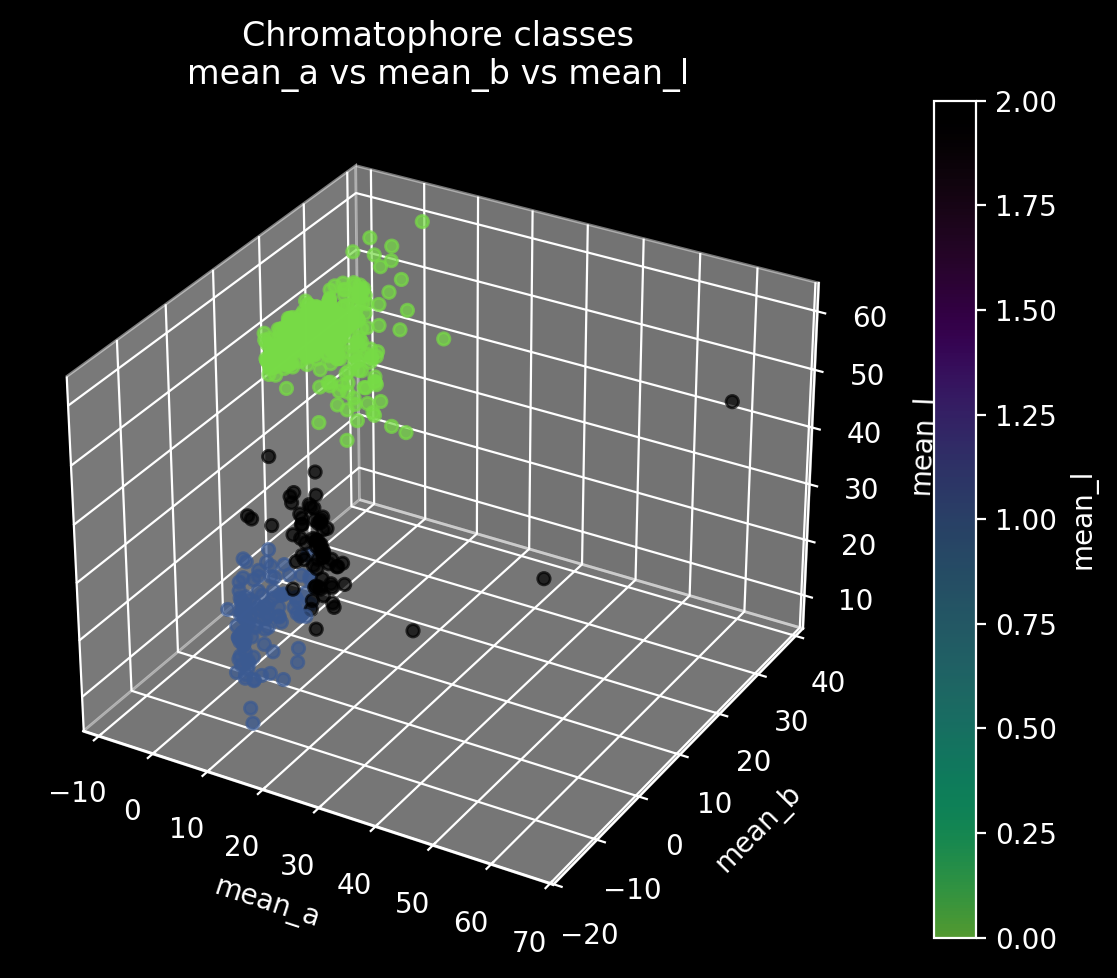

In [19]:
# Visualize per region averages and cluster identity
region_avg = chroma_data.groupby('region_id').mean(numeric_only=True)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')

# Color by cluster label
sc = ax.scatter(
    region_avg['mean_a'],
    region_avg['mean_b'],
    region_avg['mean_l'],
    c=region_avg['kmeans_label'],
    cmap='cmr.lavender_r',
    s=20,
    alpha=0.7
)

ax.set_xlabel('mean_a')
ax.set_ylabel('mean_b')
ax.set_zlabel('mean_l')
fig.colorbar(sc, ax=ax, label='mean_l')
plt.title('Chromatophore classes\nmean_a vs mean_b vs mean_l')
plt.tight_layout()
plt.show()


### Plot outlines on top of frame

In [20]:
# For one example frame show the original frame and outlines of the regions 
from octron.yolo_octron.helpers.yolo_plotting import get_outline
from tqdm import tqdm

In [21]:
frame_idx = 10
frame_at_idx = video[frame_idx]
mask_at_frame = mask_zarr[frame_idx]
data_at_frame = chroma_data[chroma_data.frame == frame_idx]

clustered_outlines = {}
for cluster in np.unique(data_at_frame.kmeans_label):
    all_outlines = []
    region_ids = data_at_frame[(data_at_frame.kmeans_label == cluster) & (data_at_frame.region_id != 0)]['region_id'].values
    for region in tqdm(region_ids): 
        region_mask = np.zeros_like(mask_at_frame)
        region_mask[mask_at_frame == region] = 255
        outline_region = get_outline(region_mask)
        all_outlines.append(outline_region)
    clustered_outlines[cluster] = all_outlines

100%|██████████| 23/23 [00:00<00:00, 25.84it/s]


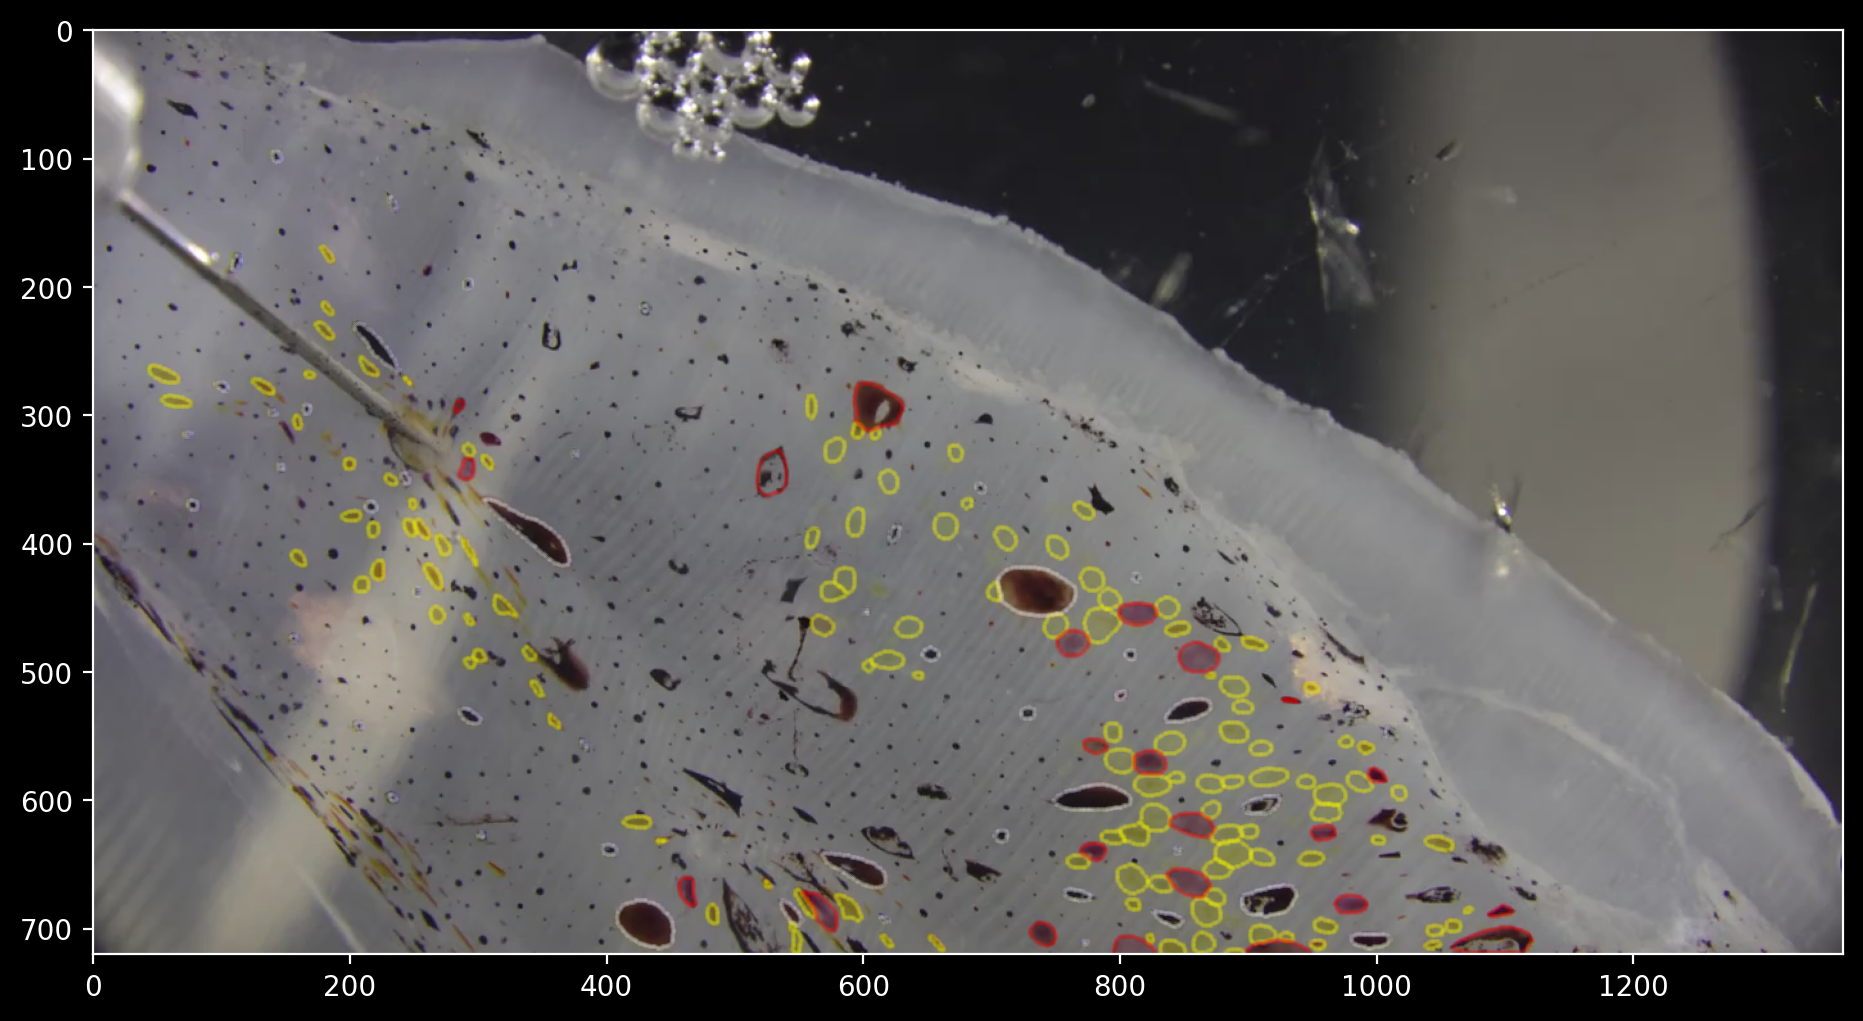

In [22]:
figure =  plt.figure(figsize=(15,6))
ax = figure.add_subplot(111)
ax.imshow(frame_at_idx)
cluster_colors = ['yellow','white','red'] # This is a bit random atm ... adjust accordingly
for cluster, cluster_out in clustered_outlines.items():
    for outline in cluster_out:
        ax.scatter(outline[:,1], outline[:,0], color=cluster_colors[cluster], s=1, alpha=.09)
    

In [36]:
from create_video import generate_label_masks_and_frames, create_mp4

### Add video and masks to napari


In [16]:
# kmeans_labels = chroma_data['kmeans_label'].dropna().unique().astype(int)
# kmeans_labels.sort()

# label_0 = []
# label_1 = []
# label_2 = []
# frames = []
# for frame_idx, frame, label_masks in generate_label_masks_and_frames(chroma_data, 
#                                                                      mask_zarr, 
#                                                                      video, 
#                                                                      kmeans_labels
#                                                                      ):
#     for label, mask in label_masks.items():
#         if label == 0:
#             label_0.append(mask)
#         elif label == 1:
#             label_1.append(mask)
#         elif label == 2:
#             label_2.append(mask)
#         else:
#             raise NotImplementedError(f'label {label} not known')
#     frames.append(frame)
# label_0 = np.stack(label_0)
# label_1 = np.stack(label_1)
# label_2 = np.stack(label_2)

In [17]:
# viewer = napari.Viewer()
# viewer.add_image(np.array(frames), name='video')
# viewer.add_labels(label_0, name='label_0')
# viewer.add_labels(label_1, name='label_1')
# viewer.add_labels(label_2, name='label_2')

### Create video from frames and chromatophore masks

In [18]:
# create_mp4(
#     chroma_data,
#     mask_zarr,
#     video,
#     export_path,
#     fps=10,
# )